In [13]:
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

datasets.load_iris().target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
# 导入输入特征和标签，并且打乱顺序
x_data = datasets.load_iris().data
#这个是四个特征值
y_data = datasets.load_iris().target
#这个是最后的0,1,2
np.random.seed(116)
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)
#训练集，测试集
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

In [15]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
#该函数是dataset核心函数之一，它的作用是把给定的元组、列表和张量等数据进行特征切片。
#切片的范围是从最外层维度开始的。如果有多个特征进行组合，那么一次切片是把每个组合的最外维度的数据切开，分成一组一组的。
#切完之后，batch32一组
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
#适配训练集，测试集

In [16]:
# 声明神经网络的参数
# 4个输入特征，3个输出值
#tf.Variable(initializer,name),参数initializer是初始化参数，name是可自定义的变量名称
#初始化一个参数，值设定为从正态分布中取值
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))
# 学习率先设定0.2
lr = 0.2
# cost函数值，记录
train_loss_results = []
# 记录每轮训练后的正确率
test_acc = []
# 将数据喂入神经网络500次，循环500次
epoch = 500
# 分批次求和
loss_all = 0
print(w1)
print(b1)

<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[ 0.08249953, -0.0683137 ,  0.19668601],
       [-0.05480815,  0.04570521,  0.1357149 ],
       [ 0.07750896, -0.16734955, -0.10294553],
       [ 0.15784004, -0.13311003,  0.06045313]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-0.09194934, -0.12376948, -0.05381497], dtype=float32)>


In [17]:
# 数据集级别的循环，每个epoch喂入一次数据集
#一个 epoch（代）是指整个数据集正向反向训练一次。
for epoch in range(epoch):
    #内层函数是和普通的一样的，每一次都套上一个batch来进行
    # batch级别的循环，每个step喂入一个batch
    for step, (x_train, y_train) in enumerate(train_db):
        # enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
        with tf.GradientTape() as tape:
            # 神经网络乘加操作
            y = tf.matmul(x_train, w1) + b1
            # 使y符合概率分布，与独热码同级，相减可求loss
            y = tf.nn.softmax(y)
            # 将标签转换为独热码格式，方便计算loss和accuracy
            y_ = tf.one_hot(y_train, depth=3)
            # 使用均方误差损失函数
            loss = tf.reduce_mean(tf.square(y_ - y))
            # 将每个step计算出来的loss累加
            loss_all += loss.numpy()
        # 计算loss对各参数的导数,自动进行梯度下降法
        grads = tape.gradient(loss, [w1, b1])

        # 参数w1和b1自更新，使用tf函数做减法
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])

    # 输出每次训练的loss
    # 因为有4组batch，所以除以4
    print("epoch:%d   loss:%f" % (epoch, loss_all/4))

    # 记录每次训练的loss，方便后面绘制loss变化曲线图
    train_loss_results.append(loss_all/4)
    # 归零，方便下次统计
    loss_all = 0

    # 调用测试数据，统计正确率
    # total_correct为正确个数, total_number为测试总数
    # 注意，此时仍为batch级别的循环，每次循环，喂入一个batch
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        # 返回y中最大值的索引，即预测的分类
        pred = tf.argmax(y, axis=1)
        # 将pred转换成y_test的类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 将bool类型转换成int类型，若分类正确correct=1，否则为0
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 计算每个batch中的correct数
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # x_test有多少行，每个batch就有多少样本
        total_number += x_test.shape[0]
    acc = total_correct/total_number
    test_acc.append(acc)
    print("test_acc:%f" % acc)
    print("****************")


epoch:0   loss:0.268519
test_acc:0.166667
****************
epoch:1   loss:0.222947
test_acc:0.166667
****************
epoch:2   loss:0.202118
test_acc:0.200000
****************
epoch:3   loss:0.180252
test_acc:0.533333
****************
epoch:4   loss:0.163798
test_acc:0.533333
****************
epoch:5   loss:0.151813
test_acc:0.533333
****************
epoch:6   loss:0.142978
test_acc:0.533333
****************
epoch:7   loss:0.136372
test_acc:0.533333
****************
epoch:8   loss:0.131324
test_acc:0.533333
****************
epoch:9   loss:0.127356
test_acc:0.533333
****************
epoch:10   loss:0.124147
test_acc:0.533333
****************
epoch:11   loss:0.121478
test_acc:0.533333
****************
epoch:12   loss:0.119200
test_acc:0.533333
****************
epoch:13   loss:0.117214
test_acc:0.533333
****************
epoch:14   loss:0.115446
test_acc:0.533333
****************
epoch:15   loss:0.113846
test_acc:0.533333
****************
epoch:16   loss:0.112377
test_acc:0.533333
*******

epoch:139   loss:0.044128
test_acc:1.000000
****************
epoch:140   loss:0.043954
test_acc:1.000000
****************
epoch:141   loss:0.043782
test_acc:1.000000
****************
epoch:142   loss:0.043613
test_acc:1.000000
****************
epoch:143   loss:0.043446
test_acc:1.000000
****************
epoch:144   loss:0.043282
test_acc:1.000000
****************
epoch:145   loss:0.043120
test_acc:1.000000
****************
epoch:146   loss:0.042961
test_acc:1.000000
****************
epoch:147   loss:0.042804
test_acc:1.000000
****************
epoch:148   loss:0.042650
test_acc:1.000000
****************
epoch:149   loss:0.042498
test_acc:1.000000
****************
epoch:150   loss:0.042347
test_acc:1.000000
****************
epoch:151   loss:0.042200
test_acc:1.000000
****************
epoch:152   loss:0.042054
test_acc:1.000000
****************
epoch:153   loss:0.041910
test_acc:1.000000
****************
epoch:154   loss:0.041768
test_acc:1.000000
****************
epoch:155   loss:0.04162

epoch:280   loss:0.032194
test_acc:1.000000
****************
epoch:281   loss:0.032152
test_acc:1.000000
****************
epoch:282   loss:0.032110
test_acc:1.000000
****************
epoch:283   loss:0.032068
test_acc:1.000000
****************
epoch:284   loss:0.032027
test_acc:1.000000
****************
epoch:285   loss:0.031986
test_acc:1.000000
****************
epoch:286   loss:0.031945
test_acc:1.000000
****************
epoch:287   loss:0.031905
test_acc:1.000000
****************
epoch:288   loss:0.031864
test_acc:1.000000
****************
epoch:289   loss:0.031824
test_acc:1.000000
****************
epoch:290   loss:0.031785
test_acc:1.000000
****************
epoch:291   loss:0.031745
test_acc:1.000000
****************
epoch:292   loss:0.031706
test_acc:1.000000
****************
epoch:293   loss:0.031667
test_acc:1.000000
****************
epoch:294   loss:0.031628
test_acc:1.000000
****************
epoch:295   loss:0.031590
test_acc:1.000000
****************
epoch:296   loss:0.03155

test_acc:1.000000
****************
epoch:420   loss:0.028112
test_acc:1.000000
****************
epoch:421   loss:0.028091
test_acc:1.000000
****************
epoch:422   loss:0.028071
test_acc:1.000000
****************
epoch:423   loss:0.028051
test_acc:1.000000
****************
epoch:424   loss:0.028031
test_acc:1.000000
****************
epoch:425   loss:0.028011
test_acc:1.000000
****************
epoch:426   loss:0.027991
test_acc:1.000000
****************
epoch:427   loss:0.027971
test_acc:1.000000
****************
epoch:428   loss:0.027951
test_acc:1.000000
****************
epoch:429   loss:0.027932
test_acc:1.000000
****************
epoch:430   loss:0.027912
test_acc:1.000000
****************
epoch:431   loss:0.027892
test_acc:1.000000
****************
epoch:432   loss:0.027873
test_acc:1.000000
****************
epoch:433   loss:0.027854
test_acc:1.000000
****************
epoch:434   loss:0.027834
test_acc:1.000000
****************
epoch:435   loss:0.027815
test_acc:1.000000
******

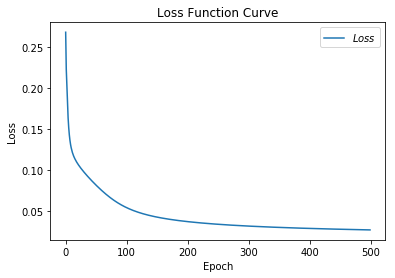

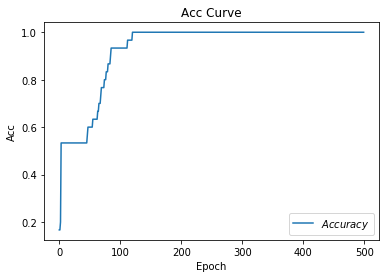

In [18]:
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()